In [1]:
import cv2
import mediapipe as mp
import pandas as pd

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

## Helper Function

create_df creates the dataframe with the features except Action

In [3]:
def create_df(df):
    df['video_id'] = 0
    df['frame_count'] = 0
    df['fps'] = 0
    for i in range(99):
        df[i] = 0
    return df

ret_Coord fills out the frame number, video id, and coordinates for each joints of each frame

In [4]:
def ret_Coord(video_id, frame, landmarks):
    result = []
    result.append(int(video_id)) # video_id
    result.append(frame) # frame_count
    # fps
    result.append(coordinates.iloc[coordinates.loc[coordinates['video_id'] == video_id].index[0]].fps)
    for lndmk in landmarks:
        result.append(float(str(lndmk).split('\n')[0].split(':')[1][1:]))
        result.append(float(str(lndmk).split('\n')[1].split(':')[1][1:]))
        result.append(float(str(lndmk).split('\n')[2].split(':')[1][1:]))
    return result

mark_false improves performance of the pose estimation by marking the image as not writeable to pass by reference

In [5]:
def mark_false(image, pose):
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)
    return results

## Extracting 3D Coordinates

In [6]:
# Necessary to find actions & maintain frames
annotated = pd.read_csv("annotated.csv", index_col = 0)
coordinates = pd.read_csv("coordinates.csv", index_col = 0)

In [37]:
def extract_coordinates(annotated, coordinates):    
    # Create our data frames
    data = pd.DataFrame()
    create_df(data)
    data['actions'] = ''
    
    df = pd.DataFrame()
    create_df(df)
    
    # remove extentions from file names so we do not miss any video for training
    for i in annotated['name']:
        if i[-4:] == '.avi' or i[-4:] == '.mp4':
            annotated = annotated.replace(i,i[:-4])
            print(annotated)
            
    # start reading file names to perform 3D coordinate extraction
    import os
    
    # PLEASE PUT YOUR OWN PATH TO THE FITNESS VIDEOS BELOW -----------------------
    path = 'Fitness_videos/'
    
    
    files = os.listdir(path)
    for video in files:
        video_path = path + str(video)

        # Checking if the video name matches with the name in the annotated csv file and gets video id
        try:
            videoid = int(annotated.loc[annotated['name'] == video[:-4]].video_id)
        except:
            continue

        # Check if the video exists in the dataframe already  
        if len(data.loc[data['video_id'] == videoid]) <= 0:
            cap = cv2.VideoCapture(video_path)
            count = 0
            with mp_pose.Pose(
                min_detection_confidence=0.3,
                min_tracking_confidence=0.3) as pose:
                while cap.isOpened():
                    success, image = cap.read()
                    if not success:
                        print("Ignoring empty camera frame.")
                        break      
                    count += 1
                    results = mark_false(image, pose)

                    # Check if the coordinate exist for each frame
                    if not results.pose_landmarks:
                        continue

                    df.loc[len(df.index)] = ret_Coord(videoid,count,results.pose_landmarks.landmark)

            # Checking the difference of the frames for data from BlazePose and MoveNet                                     

            if len(df) > len(coordinates.loc[coordinates['video_id'] == videoid].actions):
                diff = len(df)-len(coordinates.loc[coordinates['video_id'] == videoid].actions)
                for x in range(1,diff+1):
                    df.drop(len(df)-x, inplace=True)
                df['actions'] = list(coordinates.loc[coordinates['video_id'] == videoid].actions)
                data = pd.concat([data, df], ignore_index = True)

            elif len(df) < len(coordinates.loc[coordinates['video_id'] == videoid].actions):
                diff = len(coordinates.loc[coordinates['video_id'] == videoid].actions) - len(df)
                df['actions'] = list(coordinates.loc[coordinates['video_id'] == videoid].actions)[:-diff]
                data = pd.concat([data, df], ignore_index = True)

            else:
                df['actions'] = list(coordinates.loc[coordinates['video_id'] == videoid].actions)
                data = pd.concat([data, df], ignore_index = True)

            # Refresh the Dataframe for the new frame 
            df = pd.DataFrame()
            create_df(df)
            cap.release()

        else:
            # When the video is already in the dataset
            continue
        data.to_csv("blazepose_coordinates_main.csv")

In [ ]:
extract_coordinates(annotated, coordinates)

In [7]:
# reading csv file for the current blazepose_coordinates 
data = pd.read_csv("blazepose_coordinates_main.csv", index_col = 0)

## Data Preprocessing

In [8]:
#### NEW CLASSES HERE ####

# Excersices can be broadly categorized as: https://www.livestrong.com/article/534321-five-types-of-fitness-training/
## High intensity/speed
aerobic = ['jump_rope','jumping_jacks','dancing','jumping', 'x_jumps', 'running', 'all_fours_warm_up',
  'skii_hops','squat_jumps', 'lateral_squad_jumps','lateral_squat_jumps','lateral_shuffle','walking']

coordination_agility = ['agility_feet', 'run_in_place','standing_skips','high_knees', 
  'mountain_climbers','mountain_climber','boxing','high_knee_sprints','high_knee_sprint', 
  'burpy_crawl_combo','burpy', 'pace_skips', 'criss_cross','cross_crunches','surfer_hops',
  'split_hop','lower_knee_hop'] # Could also fit in as a subclass of aerobic activities
# Could maybe also fit in with calisthenics?: 'burpy_crawl_combo','burpy'

## NOTE: Uncomment if combining coordination_agility with aerobic
# [aerobic.append(item) for item in coordination_agility]

## Medium intensity/speed and lifting 
# each below are subtypes of strength training (can use uniquely or put under strength training)
weight_bearing = ['bodyweight_squats','lateral_lunges','lunges','squats','body_weight_squats',
  'lateral_squat_walk_reverse_lundge','squat_hold_reverse_lundge','lateral_squat_walk_reverse_lundge',
  'body_weight_squat_toes','drop_squats']

#non_wieght_bearing = ['torso_up_double_leg_extension', 'hamstring_curl_right','hamstring_curl_left'] # (aka prone strength training)

calisthenics = ['knees_to_elbow', 'loaded_beast_push_up','modified_push_ups','crunches','pushups',
   'pullups','wall_pushups','pulse_ups_right','pulse_ups_left','straight_left_leg_pulse'] # (bodyweight excersizes)

weightlifting = ['bench_press','triceps','donkey_press','front_press','front_up_pulse']

## NOTE: Uncomment below if combining above classes into single strength training class
# comb_list =[weight_bearing, non_wieght_bearing, calisthenics, weightlifting]
# strength_training = [item for sublist in comb_list for item in sublist] # flat strength training list if single class preferred.

##### Lower intensity/speed (flexibility, stability) ######
balance_stability = ['bear_hold_knee_taps','bear_hold_shoulder_taps','bear_hold',
  'fullbody_walkouts', 'lay_down_knees_up', 'lay_down_one_knee_up','lay_down_knee_up_down',
  'lay_down_knee_swing_shoulder_blades_up','fire_hydrants','roll_up','alternating_deadbug',
  'single_bent_leg_lower','double_bent_leg_lower', 'double_leg_extension', 'upper_body_up_criss_cross',
  'bear_hold_taps','bear_crawl','forward_plank','left_side_plank','right_side_plank','arm_plank',
  'modified_arm_plank','left_side_plank_reaching','right_side_plank_reaching','kickbacks_right_glute',
  'straight_right_leg_pulse','kickbacks_left_glute','hip_bridge','forearm_plank','high_plank',
  'high_plank_right_leg_press','push_hip_up_right_leg','push_hip_up_left_leg','high_plank_shoulder_feet_combo',
  'straight_leg_lifts','push_hip_up_right_leg_up','hip_up_right_swing_down','push_hip_up_left_leg_up','hip_up_left_swing_down',
  'high_plank_left_leg_press','reverse_dog_crunch', 'all_fours_drive','forearm_plank_rocking','upper_body_up_double_leg_extension',
  'front_laying_leg_lifts','front_laying_arms_legs_lifts','plank_dynamic','plank_static','side_plank_dynamic','plank']
# Could fit in elsewhere also (calisthenics): alternating_deadbug, fire_hydrants, kickbacks_right_glute, 

flexibility = ['yoga,stretching','streching','yoga,','yoga,ground','yoga,all_four','yoga,standing'
  'strech','stretching', 'down_dog','up_dog','runners_lundge_reach','table_top','all_fours',
   'knees_to_chest','cat_cow','all_fours_elbow_spine_stretch','up_down_dog']
# Could be further split into dynamic and static stretches

idle = ['idle','all_fours_idle','standing','standing,talking','talking,walking','talking','standing_idle','standing_writing','walking_idle','kneeling_idle','table_top_position_idle','sitting','sitting_idle' 'laying_flat','laying_down_idle','laydown_faceup','laying_down_face_up','front_laying_position','laying_down_flat','laydown_face_up','laydown_flat','front_laying_idle', 'hanging']
doubt = ['transition','glutes','shuffle_position', 'adjusting','pointing']
remove = ['slides', 'off_screen', 'slide', 'pointing', 'offscreen','intro_page']

In [9]:
def change_actions(x):
    if x in aerobic:
        return 'aerobic'
    elif x in coordination_agility:
        return 'coordination_agility'
    elif x in weight_bearing:
        return 'weight_bearing'
    elif x in calisthenics:
        return 'calisthenics'
    elif x in weightlifting:
        return 'weightlifting'
    elif x in balance_stability:
        return 'balance_stability'
    elif x in flexibility:
        return 'flexibility'
    elif x in remove:
        return 'remove'
    elif x in doubt:
        return "doubt"
    else:
        return 'idle'

In [10]:
def preprocess_data(annotated, data):
    req = annotated.iloc[:,3:].values.tolist()
    flatten = [items for lists in req for items in lists]
    flatten = [x for x in flatten if str(x) != 'nan']
    count_dict={}
    for action in flatten:
        if action in count_dict:
            count_dict[action]+=1
        else:
            count_dict[action]=1

    count = pd.DataFrame.from_dict(count_dict,orient = 'index')
    count.reset_index(inplace=True)
    count = count.rename(columns = {'index':'actions'})
    count['six_class']= count['actions'].apply(lambda x: change_actions(x))
    data['target']= data['actions'].apply(lambda x: change_actions(x))
    data.drop(['actions'] ,axis = 1,inplace = True)

In [11]:
preprocess_data(annotated, data)

## Modelling & Get Result

In [13]:
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy import stats

# Function to return the diffrence in coordinate of xth frame and x+nth frame
def data_transform(data, n, step, test =False):  
    if test == False:
        segments = []
        labels = []
        video_id = []
        for id in data['video_id'].unique():
            sub_set = data[data["video_id"] == id]
            for i in range(0, sub_set.shape[0] - n, step):
                values = ((sub_set.iloc[i+n, 3:102] - sub_set.iloc[i, 3:102]) / sub_set.iloc[i+n, 3:102])
                label = stats.mode(sub_set['target'][i: i+n])[0][0]
                segments.append([values.append(sub_set.iloc[i+n, 3:102])])
                labels.append(label)
        reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-n,198)
        df = pd.DataFrame(reshaped_segments)
        df['target'] = labels       
        return(df)       
    else:
        segments = []
        data = pd.DataFrame(points) 
        for i in range(0, data.shape[0] - n, step):
            values = ((data.iloc[i+n, :] - data.iloc[i, :]) / data.iloc[i+n, :])
            segments.append([values.append(data.iloc[i+n, :])])
        reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-n,198)
        return(reshaped_segments)

In [14]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score
def run_extratrees(data):
    # running the data_transform function(feature engineering)
    data_transformed = data_transform(data, 3, 3)
    remove_from_target = ['doubt', 'remove']
    data_transformed = data_transformed[~data_transformed['target'].isin(remove_from_target)]
    # choose X and y
    X = data_transformed.iloc[:,:-1]
    y = data_transformed['target']
    # changing the target value to numeric value to fit the data
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    # split the data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, shuffle  = True)
    #run extratrees with n_estimators = 500
    clf_extra = ExtraTreesClassifier(n_estimators = 500, random_state=42)
    clf_extra.fit(X_train, y_train)
    
    predictions  = clf_extra.predict(X_test) 
    preds_probs = clf_extra.predict_proba(X_test)
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    precision = precision_score(y_test, predictions,average = 'micro', pos_label=1)
    recall = recall_score(y_test, predictions,average = 'micro', pos_label=1)
    print("ACCURACY PER INSTANCE:" ,accuracy)
    print("F1_score:" ,f1)
    print("Precision:", precision)
    print("Recall:",recall)  
    (unique,count) = np.unique(y_train, return_counts=True)
    class_labels = unique
    plt.figure(figsize = (16,6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y_test , predictions)),annot=True, fmt="d",
                xticklabels = class_labels, yticklabels = class_labels)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    print(classification_report(y_test, predictions))
    plt.show()

ACCURACY PER INSTANCE: 0.9795632442968965
F1_score: 0.9763796525086299
Precision: 0.9795632442968965
Recall: 0.9795632442968965
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1888
           1       0.99      0.99      0.99      7650
           2       0.99      0.99      0.99      4271
           3       0.97      0.97      0.97      4423
           4       0.99      0.99      0.99      5887
           5       0.96      0.96      0.96      4425
           6       0.97      0.98      0.98      3386
           7       0.99      0.96      0.98       903

    accuracy                           0.98     32833
   macro avg       0.98      0.97      0.98     32833
weighted avg       0.98      0.98      0.98     32833



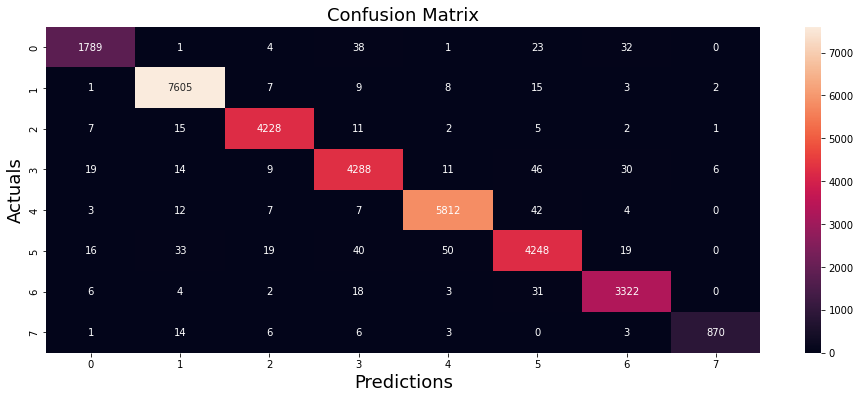

In [15]:
run_extratrees(data)